In [1]:
import pandas as pd
import numpy as np
import pickle
import cv2
from scipy.ndimage import binary_dilation, binary_erosion
from skimage.measure import EllipseModel
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import progressbar


# ファイルの読み込み
particle_movements_file = 'particle_movements.csv'
particle_clusters_file = 'particle_clusters.pkl'

# CSVファイルの読み込み
particle_movements = pd.read_csv(particle_movements_file)

# Pickleファイルの読み込み
with open(particle_clusters_file, 'rb') as f:
    particle_clusters = pickle.load(f)

  0% (0 of 64) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  3% (2 of 64) |                         | Elapsed Time: 0:00:00 ETA:   0:00:11
  4% (3 of 64) |#                        | Elapsed Time: 0:00:00 ETA:   0:00:10
  7% (5 of 64) |#                        | Elapsed Time: 0:00:00 ETA:   0:00:07
  9% (6 of 64) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:09
 14% (9 of 64) |###                      | Elapsed Time: 0:00:01 ETA:   0:00:07
 18% (12 of 64) |####                    | Elapsed Time: 0:00:01 ETA:   0:00:05
 21% (14 of 64) |#####                   | Elapsed Time: 0:00:01 ETA:   0:00:05
 23% (15 of 64) |#####                   | Elapsed Time: 0:00:01 ETA:   0:00:05
 26% (17 of 64) |######                  | Elapsed Time: 0:00:01 ETA:   0:00:05
 29% (19 of 64) |#######                 | Elapsed Time: 0:00:02 ETA:   0:00:05
 31% (20 of 64) |#######                 | Elapsed Time: 0:00:03 ETA:   0:00:07
 32% (21 of 64) |#######                

Particle 0:
  Time bin 6685.838671875001: Size 73.22539027985952, Position (175.90691964285713, 442.0467075892857)
Particle 1:
  Time bin 6633.263020833334: Size 35.97224585794956, Position (193.03125, 83.19010416666667)
Particle 2:
  Time bin 9893.454545454546: Size 22.397639785261518, Position (221.8181818181818, 321.90909090909093)
Particle 3:
  Time bin 14280.8: Size 4.1716698464317385, Position (231.8, 425.6)
Particle 4:
  Time bin 14272.0: Size 10.080283037899198, Position (14.0, 343.0)
Particle 9:
  Time bin 68896.4: Size 10.94483740669714, Position (61.4, 229.8)
Particle 10:
  Time bin 78673.8: Size 6.407613508068978, Position (19.6, 395.2)
Particle 16:
  Time bin 179223.7142857143: Size 12.406850655235377, Position (78.42857142857143, 415.0)
Particle 19:
  Time bin 262553.0: Size 7.588582330860648, Position (355.8, 247.4)
Particle 26:
  Time bin 315299.0: Size 5.787411793179132, Position (127.71428571428572, 418.0)
Particle 30:
  Time bin 348027.6: Size 20.58930335928333, Posi

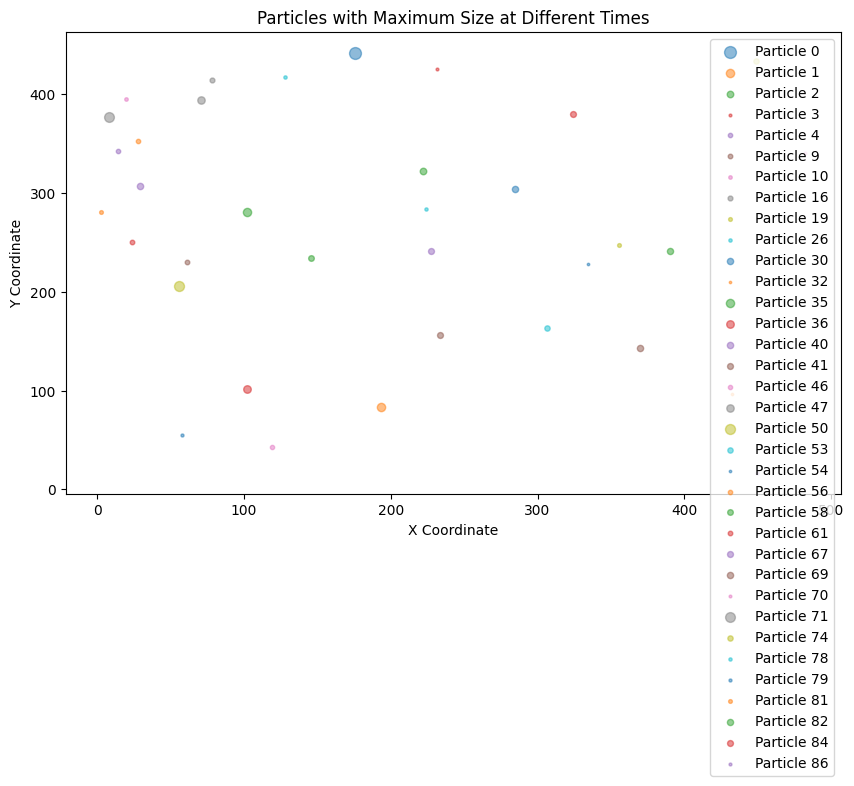

In [8]:
# 楕円近似によるサイズの計算
def calculate_ellipse_size(points):
    ellipse = EllipseModel()
    if ellipse.estimate(points):
        xc, yc, a, b, theta = ellipse.params
        return max(a, b) * 2  # 長い方の軸をサイズとする
    return 0

# 画像処理操作
def process_image(points, img_size=(500, 500)):
    img = np.zeros(img_size, dtype=np.uint8)
    for point in points:
        x, y = point[:2]  # x, y座標のみを使用
        if 0 <= int(x) < img_size[1] and 0 <= int(y) < img_size[0]:
            img[int(y), int(x)] = 1
    img = binary_dilation(img).astype(np.uint8)
    img = binary_erosion(img).astype(np.uint8)
    img = binary_erosion(img).astype(np.uint8)
    img = binary_dilation(img).astype(np.uint8)
    return img

# 粒子ごとの最大サイズを保存する辞書
particle_max_size = {}

# プログレスバーの設定
bar = progressbar.ProgressBar(max_value=len(particle_clusters.keys()))

# 粒子ごとに最大サイズを計算
for idx, particle_id in enumerate(particle_clusters.keys()):
    particle_data = particle_movements[particle_movements['particle_id'] == particle_id]
    max_size = 0
    max_size_time = None
    max_size_position = None
    
    for time_bin in particle_data['time'].unique():
        time_bin_data = particle_data[particle_data['time'] == time_bin]
        
        if particle_id in particle_clusters:
            cluster_points = []
            for points in particle_clusters[particle_id]:
                cluster_points.extend(points[:, :2])  # x, y座標のみを使用
            points = np.array(cluster_points)
            if points.size == 0:
                continue
            img = process_image(points)
            
            # 輪郭の抽出
            contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            # 最大の輪郭を選択
            if len(contours) > 0:
                largest_contour = max(contours, key=cv2.contourArea)
                if len(largest_contour) >= 5:  # 楕円近似には少なくとも5点が必要
                    size = calculate_ellipse_size(largest_contour[:, 0, :])
                    if size > max_size:
                        max_size = size
                        max_size_time = time_bin
                        max_size_position = (time_bin_data['x'].mean(), time_bin_data['y'].mean())
    
    if max_size_time is not None:
        particle_max_size[particle_id] = (max_size_time, max_size, max_size_position)

    # プログレスバーを更新
    bar.update(idx + 1)

# 結果を表示
for particle_id, (time_bin, size, position) in particle_max_size.items():
    print(f"Particle {particle_id}:")
    print(f"  Time bin {time_bin}: Size {size}, Position {position}")

# 最大サイズの時間と座標をプロット
plt.figure(figsize=(10, 6))
for particle_id, (time_bin, size, position) in particle_max_size.items():
    plt.scatter(position[0], position[1], s=size, label=f'Particle {particle_id}', alpha=0.5)

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Particles with Maximum Size at Different Times')
plt.legend()
plt.show()

In [7]:
import pandas as pd
import numpy as np
import pickle
import cv2
from scipy.ndimage import binary_dilation, binary_erosion
from skimage.measure import EllipseModel
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import progressbar


# ファイルの読み込み
particle_movements_file = 'particle_movements.csv'
particle_clusters_file = 'particle_clusters.pkl'

# CSVファイルの読み込み
particle_movements = pd.read_csv(particle_movements_file)

# Pickleファイルの読み込み
with open(particle_clusters_file, 'rb') as f:
    particle_clusters = pickle.load(f)
    
# 楕円近似によるサイズの計算
def calculate_ellipse_params(points):
    ellipse = EllipseModel()
    if ellipse.estimate(points):
        return ellipse.params
    return None

# 画像処理操作
def process_image(points, img_size=(1280, 720)):
    img = np.zeros(img_size, dtype=np.uint8)
    for point in points:
        x, y = point[:2]  # x, y座標のみを使用
        if 0 <= int(x) < img_size[1] and 0 <= int(y) < img_size[0]:
            img[int(y), int(x)] = 1
    img = binary_dilation(img).astype(np.uint8)
    img = binary_erosion(img).astype(np.uint8)
    img = binary_erosion(img).astype(np.uint8)
    img = binary_dilation(img).astype(np.uint8)
    return img

# 粒子ごとの最大サイズを保存する辞書
particle_max_ellipse = {}

# プログレスバーの設定
bar = progressbar.ProgressBar(max_value=len(particle_clusters.keys()))

# 粒子ごとに最大サイズを計算
for idx, particle_id in enumerate(particle_clusters.keys()):
    particle_data = particle_movements[particle_movements['particle_id'] == particle_id]
    max_area = 0
    max_ellipse_params = None
    max_size_time = None
    max_size_position = None
    
    for time_bin in particle_data['time'].unique():
        time_bin_data = particle_data[particle_data['time'] == time_bin]
        
        if particle_id in particle_clusters:
            cluster_points = []
            for points in particle_clusters[particle_id]:
                cluster_points.extend(points[:, :2])  # x, y座標のみを使用
            points = np.array(cluster_points)
            if points.size == 0:
                continue
            img = process_image(points)
            
            # 輪郭の抽出
            contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            # 最大の輪郭を選択
            if len(contours) > 0:
                largest_contour = max(contours, key=cv2.contourArea)
                if len(largest_contour) >= 5:  # 楕円近似には少なくとも5点が必要
                    ellipse_params = calculate_ellipse_params(largest_contour[:, 0, :])
                    if ellipse_params is not None:
                        xc, yc, a, b, theta = ellipse_params
                        area = np.pi * a * b
                        if area > max_area:
                            max_area = area
                            max_ellipse_params = ellipse_params
                            max_size_time = time_bin
                            max_size_position = (time_bin_data['x'].mean(), time_bin_data['y'].mean())
    
    if max_ellipse_params is not None:
        particle_max_ellipse[particle_id] = (max_size_time, max_ellipse_params, max_size_position)

    # プログレスバーを更新
    bar.update(idx + 1)

# 結果を表示
for particle_id, (time_bin, ellipse_params, position) in particle_max_ellipse.items():
    xc, yc, a, b, theta = ellipse_params
    print(f"Particle {particle_id}:")
    print(f"  Time bin {time_bin}: Ellipse center=({xc}, {yc}), axes=({a}, {b}), angle={theta}, Position {position}")

  0% (0 of 64) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  3% (2 of 64) |                         | Elapsed Time: 0:00:01 ETA:   0:00:33
  4% (3 of 64) |#                        | Elapsed Time: 0:00:01 ETA:   0:00:34
  6% (4 of 64) |#                        | Elapsed Time: 0:00:01 ETA:   0:00:27
  7% (5 of 64) |#                        | Elapsed Time: 0:00:02 ETA:   0:00:24
  9% (6 of 64) |##                       | Elapsed Time: 0:00:03 ETA:   0:00:31
 10% (7 of 64) |##                       | Elapsed Time: 0:00:03 ETA:   0:00:26
 14% (9 of 64) |###                      | Elapsed Time: 0:00:04 ETA:   0:00:24
 17% (11 of 64) |####                    | Elapsed Time: 0:00:04 ETA:   0:00:20
 18% (12 of 64) |####                    | Elapsed Time: 0:00:04 ETA:   0:00:19
 20% (13 of 64) |####                    | Elapsed Time: 0:00:04 ETA:   0:00:18
 21% (14 of 64) |#####                   | Elapsed Time: 0:00:05 ETA:   0:00:18
 23% (15 of 64) |#####                  

Particle 0:
  Time bin 6685.838671875001: Ellipse center=(131.77948590697167, 493.28479022851104), axes=(70.99910209017742, 9.83854325474449), angle=2.3219398623280965, Position (175.90691964285713, 442.0467075892857)
Particle 1:
  Time bin 6633.263020833334: Ellipse center=(190.67001162120278, 97.04867020878865), axes=(17.98612292897478, 5.188211885217585), angle=1.7609145342247157, Position (193.03125, 83.19010416666667)
Particle 2:
  Time bin 9893.454545454546: Ellipse center=(249.87112849561638, 369.4213045555307), axes=(11.198819892630759, 2.8602290916297926), angle=1.0477105293171949, Position (221.8181818181818, 321.90909090909093)
Particle 3:
  Time bin 14280.8: Ellipse center=(231.0, 427.5), axes=(2.0858349232158693, 1.4414798304743903), angle=2.7488935718910694, Position (231.8, 425.6)
Particle 4:
  Time bin 14272.0: Ellipse center=(41.64197643869471, 328.8509580665548), axes=(5.040141518949599, 3.02018386753501), angle=0.8289478384160857, Position (14.0, 343.0)
Particle 9:
 

In [1]:
import pandas as pd
import numpy as np
import pickle
import cv2
from scipy.ndimage import binary_dilation, binary_erosion
from skimage.measure import EllipseModel
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import progressbar

# ファイルの読み込み
particle_movements_file = 'particle_movements.csv'
particle_clusters_file = 'particle_clusters.pkl'

# CSVファイルの読み込み
particle_movements = pd.read_csv(particle_movements_file)

# Pickleファイルの読み込み
with open(particle_clusters_file, 'rb') as f:
    particle_clusters = pickle.load(f)

In [4]:
import pandas as pd
import numpy as np
import pickle
import cv2
from scipy.ndimage import binary_dilation, binary_erosion
from skimage.measure import EllipseModel
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import progressbar
from sklearn.decomposition import PCA

  0% (0 of 64) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  3% (2 of 64) |                         | Elapsed Time: 0:00:01 ETA:   0:00:39
  4% (3 of 64) |#                        | Elapsed Time: 0:00:01 ETA:   0:00:39
  6% (4 of 64) |#                        | Elapsed Time: 0:00:02 ETA:   0:00:30
  7% (5 of 64) |#                        | Elapsed Time: 0:00:02 ETA:   0:00:26
  9% (6 of 64) |##                       | Elapsed Time: 0:00:03 ETA:   0:00:37
 10% (7 of 64) |##                       | Elapsed Time: 0:00:03 ETA:   0:00:32
 14% (9 of 64) |###                      | Elapsed Time: 0:00:04 ETA:   0:00:29
 17% (11 of 64) |####                    | Elapsed Time: 0:00:04 ETA:   0:00:24
 18% (12 of 64) |####                    | Elapsed Time: 0:00:05 ETA:   0:00:23
 20% (13 of 64) |####                    | Elapsed Time: 0:00:05 ETA:   0:00:21
 21% (14 of 64) |#####                   | Elapsed Time: 0:00:06 ETA:   0:00:21
 23% (15 of 64) |#####                  

Particle 0:
  Time bin 6685.838671875001: Ellipse center=(33.336406141309205, 3.2771269447733427), axes=(28.068044680215092, 2.3974949235809797), angle=3.136859892981095, Position (175.90691964285713, 442.0467075892857)
Particle 9:
  Time bin 68896.4: Ellipse center=(27.0, 2.5), axes=(1.4999999999999998, 1.0606601717798212), angle=1.5707963267948966, Position (61.4, 229.8)
Particle 16:
  Time bin 179223.7142857143: Ellipse center=(22.5, 2.0), axes=(1.5, 1.0606601717798214), angle=0.0, Position (78.42857142857143, 415.0)
Particle 27:
  Time bin 328678.85714285716: Ellipse center=(314.0, 3.0000000000000004), axes=(2.3094010767585025, 1.788854381999833), angle=2.3561944901923453, Position (16.714285714285715, 498.2857142857143)
Particle 28:
  Time bin 335687.8: Ellipse center=(6.798416270851624, 2.0), axes=(4.36788117021033, 0.9961398504110538), angle=0.0, Position (886.0, 264.8)
Particle 36:
  Time bin 400078.6: Ellipse center=(4.713412966880074, 2.6466885666141304), axes=(3.447163682815

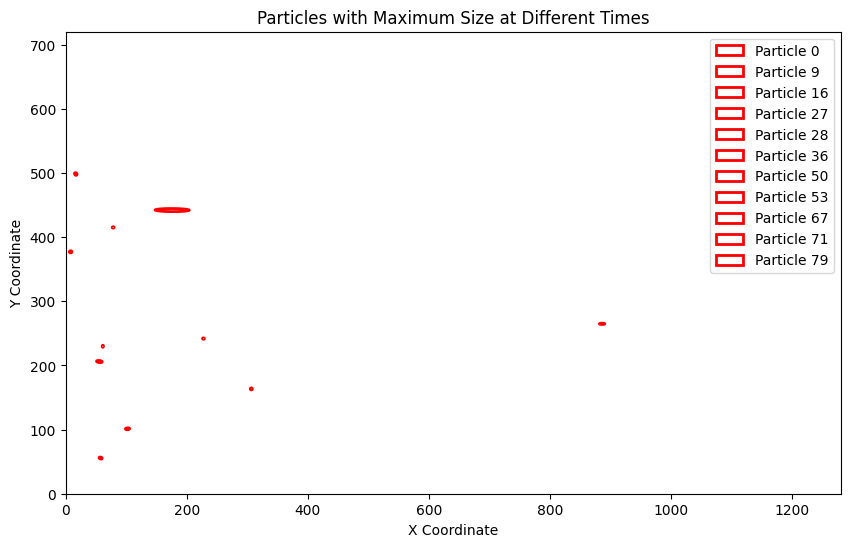

In [5]:
# 楕円近似によるサイズの計算
def calculate_ellipse_params(points):
    ellipse = EllipseModel()
    if ellipse.estimate(points):
        return ellipse.params
    return None

# 画像処理操作
def process_image(points, img_size=(1280, 720)):
    img = np.zeros(img_size, dtype=np.uint8)
    for point in points:
        x, y = point[:2]  # x, y座標のみを使用
        if 0 <= int(x) < img_size[1] and 0 <= int(y) < img_size[0]:
            img[int(y), int(x)] = 1
    img = binary_dilation(img).astype(np.uint8)
    img = binary_erosion(img).astype(np.uint8)
    img = binary_erosion(img).astype(np.uint8)
    img = binary_dilation(img).astype(np.uint8)
    return img

# PCAを用いて最適な視点を見つける
def event_alignment(cluster_points):
    # 3次元データの主成分分析 (PCA) を実施
    pca = PCA(n_components=2)
    aligned_points = []
    for points in cluster_points:
        transformed_points = pca.fit_transform(points)
        aligned_points.append(transformed_points)
    return aligned_points

# 粒子ごとの最大サイズを保存する辞書
particle_max_ellipse = {}

# プログレスバーの設定
bar = progressbar.ProgressBar(max_value=len(particle_clusters.keys()))

# 粒子ごとに最大サイズを計算
for idx, particle_id in enumerate(particle_clusters.keys()):
    particle_data = particle_movements[particle_movements['particle_id'] == particle_id]
    max_area = 0
    max_ellipse_params = None
    max_size_time = None
    max_size_position = None
    
    for time_bin in particle_data['time'].unique():
        time_bin_data = particle_data[particle_data['time'] == time_bin]
        
        if particle_id in particle_clusters:
            cluster_points = []
            for points in particle_clusters[particle_id]:
                cluster_points.append(points)
            
            # イベントアライメントを適用
            aligned_points = event_alignment(cluster_points)
            
            points = np.vstack(aligned_points)
            if points.size == 0:
                continue
            img = process_image(points)
            
            # 輪郭の抽出
            contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            # 最大の輪郭を選択
            if len(contours) > 0:
                largest_contour = max(contours, key=cv2.contourArea)
                if len(largest_contour) >= 5:  # 楕円近似には少なくとも5点が必要
                    ellipse_params = calculate_ellipse_params(largest_contour[:, 0, :])
                    if ellipse_params is not None:
                        xc, yc, a, b, theta = ellipse_params
                        area = np.pi * a * b
                        if area > max_area:
                            max_area = area
                            max_ellipse_params = ellipse_params
                            max_size_time = time_bin
                            max_size_position = (time_bin_data['x'].mean(), time_bin_data['y'].mean())
    
    if max_ellipse_params is not None:
        particle_max_ellipse[particle_id] = (max_size_time, max_ellipse_params, max_size_position)

    # プログレスバーを更新
    bar.update(idx + 1)

# 結果を表示
for particle_id, (time_bin, ellipse_params, position) in particle_max_ellipse.items():
    xc, yc, a, b, theta = ellipse_params
    print(f"Particle {particle_id}:")
    print(f"  Time bin {time_bin}: Ellipse center=({xc}, {yc}), axes=({a}, {b}), angle={theta}, Position {position}")

# 楕円の時間と座標をプロット
plt.figure(figsize=(10, 6))
ax = plt.gca()

# データのプロット範囲を設定
ax.set_xlim(0, 1280)
ax.set_ylim(0, 720)

for particle_id, (time_bin, ellipse_params, position) in particle_max_ellipse.items():
    xc, yc, a, b, theta = ellipse_params
    ellipse = patches.Ellipse(xy=(position[0], position[1]), width=2*a, height=2*b, angle=np.degrees(theta),
                              edgecolor='r', fc='None', lw=2, label=f'Particle {particle_id}')
    ax.add_patch(ellipse)

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Particles with Maximum Size at Different Times')
plt.legend()
plt.show()

  0% (0 of 64) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 14% (9 of 64) |###                      | Elapsed Time: 0:00:00 ETA:   0:00:00
 29% (19 of 64) |#######                 | Elapsed Time: 0:00:00 ETA:   0:00:00
 31% (20 of 64) |#######                 | Elapsed Time: 0:00:00 ETA:   0:00:00
 43% (28 of 64) |##########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 56% (36 of 64) |#############           | Elapsed Time: 0:00:00 ETA:   0:00:00
 59% (38 of 64) |##############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 79% (51 of 64) |###################     | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (58 of 64) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00


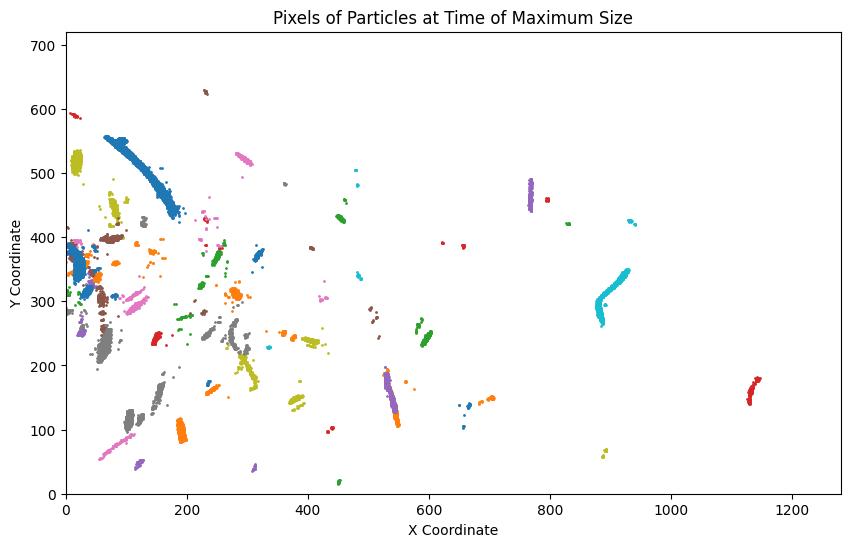

In [5]:
# 粒子ごとの最大サイズを保存する辞書
particle_max_pixels = {}

# プログレスバーの設定
bar = progressbar.ProgressBar(max_value=len(particle_clusters.keys()))

# 粒子ごとに最大サイズを計算
for idx, particle_id in enumerate(particle_clusters.keys()):
    particle_data = particle_movements[particle_movements['particle_id'] == particle_id]
    max_area = 0
    max_size_time = None
    max_cluster_points = None
    
    for time_bin in particle_data['time'].unique():
        time_bin_data = particle_data[particle_data['time'] == time_bin]
        
        if particle_id in particle_clusters:
            cluster_points = []
            for points in particle_clusters[particle_id]:
                cluster_points.extend(points[:, :2])  # x, y座標のみを使用
            points = np.array(cluster_points)
            if points.size == 0:
                continue
            
            # 面積の計算（単純に点の数を使用）
            area = points.shape[0]
            if area > max_area:
                max_area = area
                max_size_time = time_bin
                max_cluster_points = points
    
    if max_size_time is not None and max_cluster_points is not None:
        particle_max_pixels[particle_id] = max_cluster_points

    # プログレスバーを更新
    bar.update(idx + 1)

# 結果を表示
plt.figure(figsize=(10, 6))
ax = plt.gca()

# データのプロット範囲を設定
ax.set_xlim(0, 1280)
ax.set_ylim(0, 720)

# ピクセルをプロット
for particle_id, points in particle_max_pixels.items():
    ax.scatter(points[:, 0], points[:, 1], s=1)

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Pixels of Particles at Time of Maximum Size')
plt.show()

In [14]:
particle_movements['particle_id'] == 0

0        True
1        True
2        True
3        True
4        True
        ...  
1577    False
1578    False
1579    False
1580    False
1581    False
Name: particle_id, Length: 1582, dtype: bool

In [2]:
import pandas as pd
import numpy as np
import pickle
import cv2
from scipy.ndimage import binary_dilation, binary_erosion
from skimage.measure import EllipseModel
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import progressbar


# ファイルの読み込み
particle_movements_file = 'particle_movements.csv'
particle_clusters_file = 'particle_clusters.pkl'

# CSVファイルの読み込み
particle_movements = pd.read_csv(particle_movements_file)

# Pickleファイルの読み込み
with open(particle_clusters_file, 'rb') as f:
    particle_clusters = pickle.load(f)
    
# 楕円近似によるサイズの計算
def calculate_ellipse_params(points):
    ellipse = EllipseModel()
    if ellipse.estimate(points):
        return ellipse.params
    return None

# 画像処理操作
def process_image(points, img_size=(1280, 720)):
    img = np.zeros(img_size, dtype=np.uint8)
    for point in points:
        x, y = point[:2]  # x, y座標のみを使用
        if 0 <= int(x) < img_size[1] and 0 <= int(y) < img_size[0]:
            img[int(y), int(x)] = 1
    img = binary_dilation(img).astype(np.uint8)
    img = binary_erosion(img).astype(np.uint8)
    img = binary_erosion(img).astype(np.uint8)
    img = binary_dilation(img).astype(np.uint8)
    return img

# 粒子ごとの最大サイズを保存する辞書
particle_max_ellipse = {}

# プログレスバーの設定
bar = progressbar.ProgressBar(max_value=len(particle_clusters.keys()))

# 粒子ごとに最大サイズを計算
for idx, particle_id in enumerate(particle_clusters.keys()):
    particle_data = particle_movements[particle_movements['particle_id'] == particle_id]
    max_area = 0
    max_ellipse_params = None
    max_size_time = None
    max_size_position = None
    
    for time_bin in particle_data['time'].unique():
        time_bin_data = particle_data[particle_data['time'] == time_bin]
        
        if particle_id in particle_clusters:
            cluster_points = []
            for points in particle_clusters[particle_id]:
                cluster_points.extend(points[:, :2])  # x, y座標のみを使用
            points = np.array(cluster_points)
            if points.size == 0:
                continue
            img = process_image(points)
            
            # 輪郭の抽出
            contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            # 最大の輪郭を選択
            if len(contours) > 0:
                largest_contour = max(contours, key=cv2.contourArea)
                if len(largest_contour) >= 5:  # 楕円近似には少なくとも5点が必要
                    ellipse_params = calculate_ellipse_params(largest_contour[:, 0, :])
                    if ellipse_params is not None:
                        xc, yc, a, b, theta = ellipse_params
                        area = np.pi * a * b
                        if area > max_area:
                            max_area = area
                            max_ellipse_params = ellipse_params
                            max_size_time = time_bin
                            max_size_position = (time_bin_data['x'].mean(), time_bin_data['y'].mean())
    
    if max_ellipse_params is not None:
        particle_max_ellipse[particle_id] = (max_size_time, max_ellipse_params, max_size_position)

    # プログレスバーを更新
    bar.update(idx + 1)

# 結果を表示
for particle_id, (time_bin, ellipse_params, position) in particle_max_ellipse.items():
    xc, yc, a, b, theta = ellipse_params
    print(f"Particle {particle_id}:")
    print(f"  Time bin {time_bin}: Ellipse center=({xc}, {yc}), axes=({a}, {b}), angle={theta}, Position {position}")

  0% (0 of 321) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  0% (2 of 321) |                        | Elapsed Time: 0:00:00 ETA:   0:00:28
  0% (3 of 321) |                        | Elapsed Time: 0:00:00 ETA:   0:00:39
  1% (4 of 321) |                        | Elapsed Time: 0:00:01 ETA:   0:02:07
  1% (5 of 321) |                        | Elapsed Time: 0:00:02 ETA:   0:02:43
  1% (6 of 321) |                        | Elapsed Time: 0:00:04 ETA:   0:04:15
  2% (7 of 321) |                        | Elapsed Time: 0:00:05 ETA:   0:04:00
  2% (8 of 321) |                        | Elapsed Time: 0:00:07 ETA:   0:04:40
  2% (9 of 321) |                        | Elapsed Time: 0:00:18 ETA:   0:10:37
  3% (11 of 321) |                       | Elapsed Time: 0:00:18 ETA:   0:08:48
  3% (12 of 321) |                       | Elapsed Time: 0:00:19 ETA:   0:08:20
  4% (13 of 321) |                       | Elapsed Time: 0:00:19 ETA:   0:07:42
  4% (14 of 321) |#                     

Particle 2:
  Time bin 15724.183333333334: Ellipse center=(676.5759501576299, 311.93885952784404), axes=(2.072185138919466, 1.621716262666053), angle=1.4110889467560763, Position (669.8333333333333, 306.15)
Particle 3:
  Time bin 15511.166666666666: Ellipse center=(480.68858282804746, 493.304183757968), axes=(12.947096692311602, 1.6658743016605224), angle=1.6756932717871085, Position (540.1666666666666, 336.5)
Particle 4:
  Time bin 15831.666666666666: Ellipse center=(42.07236627640435, 332.75237945566056), axes=(13.141266340395452, 7.1856408099214395), angle=1.6638460338220347, Position (14.0, 344.8333333333333)
Particle 5:
  Time bin 15564.2448489011: Ellipse center=(190.19697678932104, 99.24701341861146), axes=(22.51463312136659, 5.365113098159814), angle=1.785404496735305, Position (191.4425366300366, 89.7764423076923)
Particle 6:
  Time bin 15581.352631578948: Ellipse center=(224.3515263792673, 324.4923048683332), axes=(6.239371898616004, 3.369671697020783), angle=0.91373016535070

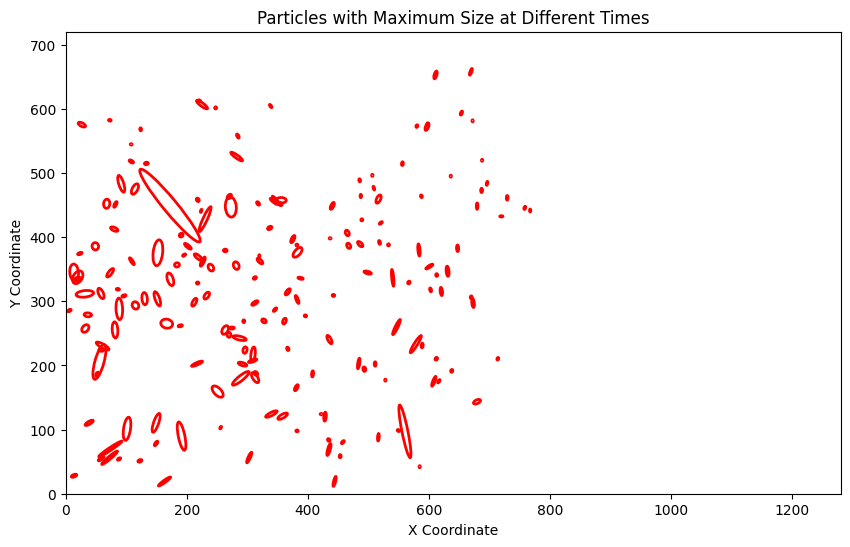

In [3]:
# 楕円の時間と座標をプロット
plt.figure(figsize=(10, 6))
ax = plt.gca()

# データのプロット範囲を設定
ax.set_xlim(0, 1280)
ax.set_ylim(0, 720)

for particle_id, (time_bin, ellipse_params, position) in particle_max_ellipse.items():
    xc, yc, a, b, theta = ellipse_params
    ellipse = patches.Ellipse(xy=(position[0], position[1]), width=2*a, height=2*b, angle=np.degrees(theta),
                              edgecolor='r', fc='None', lw=2, label=f'Particle {particle_id}')
    ax.add_patch(ellipse)

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Particles with Maximum Size at Different Times')
plt.show()